# Homework 10

**Harvard University**<br>
**Fall 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date:** Sunday, November 18th, 2018 at 11:59pm

**Instructions:**

- Upload your final answers in the form of a Jupyter notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

### Collaborators

**Joe Davison**
<br>
**Anna Davydova**
<br>
**Michael S. Emanuel**
<br>
**Dylan Randle**
<br>

<div class="answer-separator">
------------------------
</div>

In [1]:
import numpy as np
import scipy.stats
import scipy.special

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import cm

import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
# Additional imports
from numpy import exp
import pymc3 as pm
from sklearn.model_selection import train_test_split
import pickle
from typing import Dict

In [3]:
# Utility functions for serialization

def load_vartbl(fname: str) -> Dict:
    """Load a dictionary of variables from a pickled file"""
    try:
        with open(fname, 'rb') as fh:
            vartbl = pickle.load(fh)
    except:
        vartbl = dict()
    return vartbl


def save_vartbl(vartbl: Dict, fname: str) -> None:
    """Save a dictionary of variables to the given file with pickle"""
    with open(fname, 'wb') as fh:
        pickle.dump(vartbl, fh)

In [4]:
# Set font size for plots
matplotlib.rcParams.update({'font.size': 20})

## Question 1: Metropoflix and Chill (What's your Net Worth)?

**coding required**

Suppose we ask you to memorize the order of the top five movies on IMDB. When we quiz you on the order afterwards, you may not recall the correct order, but the mistakes you make in your recall can be modeled by simple probabilistic models.
  
Let's say that the top five movies are:  
1. *The Shawshank Redemption*
2. *The Godfather*
3. *The Godfather: Part II*
4. *Black Panther*
5. *Pulp Fiction*

Let's represent this ordering by the vector $\omega = (1,2,3,4,5)$. 

If you were to mistakenly recall the top five movies as:
2. *The Godfather*
3. *The Godfather: Part II*
5. *Pulp Fiction*
4. *Black Panther*
1. *The Shawshank Redemption*

We'd represent your answer by the vector $\theta = (2,3,5,4,1)$.

Unfortunately, your answer is wrong.  Fortunately (for our purposes) we have a way of quantifying just how wrong. Define the Hamming distance between two top five rankings, $\theta, \omega$, as follows:
$$d(\theta, \omega) = \sum_{i=1}^5 \mathbb{I}_{\theta_i\neq \omega_i},$$ 
where $\mathbb{I}_{\theta_i\neq \omega_i}$ is an indicator function that returns 1 if $\theta_i\neq \omega_i$, and 0 otherwise.

For example, the Hamming distance between your answer and the correct answer is $d(\theta, \omega)=4$, because you only ranked *Black Panther* correctly. 

Finally, let's suppose that the probability of giving a particular answer (expressed as $\theta$) is modeled as
$$ p(\theta \,|\, \omega, \lambda) \propto  e^{-\lambda\, d(\theta,\, \omega)}$$
where $\lambda$ can be thought of as an inverse temperature

1.1. Implement a Metropolis sampler to produce sample guesses from 500 individuals, with the $\lambda$ values, $\lambda=0.2, 0.5, 1.0$. What are the top five possible guesses?

1.2. Compute the probability that *The Shawshank Redemption* is ranked as the top movie (ranked number 1) by the Metropolis algorithm sampler. Compare the resulting probabilities for the various $\lambda$ values. 

1.3. How does $\lambda$ affect the probability that *The Shawshank Redemption* is ranked as the top movie?


In [5]:
# *************************************************************************************************
# 1.1. Implement a Metropolis sampler to produce sample guesses from 500 individuals, 
# with the λ values,  λ=0.2,0.5,1.0 . What are the top five possible guesses?
# *************************************************************************************************

# *************************************************************************************************
def hamming_dist(x: np.ndarray, y: np.ndarray):
    """Compute the Hamming Distance between two arrays"""
    return np.sum(x != y)


def proposal(x: np.ndarray):
    """Generate a proposal guess by transposing a random pair of elements in x."""
    # Initialize a copy of x
    y = x.copy()
    # Draw a random pair in [0, n)
    n: int = len(x)
    i, j = np.random.choice(n, 2, replace=False)
    # Swap the ith and jth elements
    xi, xj = x[i], x[j]
    y[i], y[j] = xj, xi
    # Return modified guess
    return y


def prob(x: np.ndarray, y: np.ndarray, lam: float):
    """The unscaled probability of guess theta given omega and the lambda parameter (inverse temperature)."""
    return exp(-lam * hamming_dist(x, y))


def metropolis(num_samp: int, lam: float, x_init: np.ndarray):
    """Metropolis Sampler for this problem"""
    # The correct order
    x_best: np.ndarray = np.array([1,2,3,4,5], dtype=np.int8)
    # Get the length n of each guess
    n: int = len(x_best)
    # Initialize array to store the samples
    samples: np.ndarray = np.empty((num_samp, n), dtype=np.int8)
    # Initialize x_prev
    x_prev: np.ndarray = x_init
    # Draw num_samp samples using Metrpolis algorithm
    # Adapted from example code in Lecture 16, p. 6
    for i in range(num_samp):
        # The proposed new point
        x_star: np.ndarray = proposal(x_prev)
        # Compare probability of the propsed point to the current one
        p_star: float = prob(x_star, x_best, lam)
        p_prev: float = prob(x_prev, x_best, lam)
        # Probability ratio
        pdf_ratio: float = p_star / p_prev
        # Randomly accept or reject the step based on pdf_ratio
        if np.random.uniform() < min(1.0, pdf_ratio):
            # Accept the step
            samples[i] = x_star
            x_prev = x_star
        else:
            # Reject the step; duplicate x_prev as a sample
            samples[i] = x_prev
    return samples


def top_five_guesses(samples: np.ndarray):
    """Given an Nx5 array of guesses, find the top five."""
    # Count the frequency of the distinct guesses
    guesses, counts = np.unique(samples, return_counts=True, axis=0)
    # Sort the guesses by their frequency
    gc = list(zip(guesses, counts))
    gc.sort(key = lambda x: x[1], reverse=True)
    # Return the top five guesses and their frequency
    gc = gc[0:5]
    guesses = [x[0] for x in gc]
    counts = [x[1] for x in gc]
    return guesses, counts

**1.1** Implement a Metropolis sampler to produce sample guesses from 500 individuals, with the $\lambda$ values, $\lambda=0.2, 0.5, 1.0$. What are the top five possible guesses?

In [6]:
# Set random seed
np.random.seed(42)
# Number of desired samples 
num_samp = 500
# Set burn-in
burn_in = 100
# Pick a random starting point
x_init = np.random.choice(5, size=5, replace=False).astype(np.int8) + 1
# Range of lambdas to test
lams = (0.2, 0.5, 1.0)
# Table for the results
sample_tbl = dict()
top_five_guesses_tbl = dict()
# Test each lambda in turn
for lam in lams:
    # Run a burn-in period of 100 samples
    discarded_samples = metropolis(burn_in, lam, x_init)
    # Run the metropolis sampler on the current value of x
    x_init = discarded_samples[-1, :]
    samples = metropolis(num_samp, lam, x_init)
    # Save samples in the table
    sample_tbl[lam] = samples
    # Get the top 5 guesses and their frequencies
    guesses, counts = top_five_guesses(samples)
    # Save top five guesses to table
    top_five_guesses_tbl[lam] = top_five_guesses(samples)

# Display results
for lam in lams:
    guesses, counts = top_five_guesses_tbl[lam]
    print(f'\nLambda = {lam:0.1f}.  Top five guesses and frequency:')
    for i in range(5):
        print(f'{guesses[i]}, {counts[i]:3} ({counts[i]/num_samp*100:0.2f})%.')



Lambda = 0.2.  Top five guesses and frequency:
[1 2 3 4 5],  12 (2.40)%.
[1 4 3 5 2],  10 (2.00)%.
[2 4 3 5 1],  10 (2.00)%.
[1 2 4 3 5],   9 (1.80)%.
[1 4 3 2 5],   9 (1.80)%.

Lambda = 0.5.  Top five guesses and frequency:
[1 2 4 3 5],  14 (2.80)%.
[1 2 5 4 3],  14 (2.80)%.
[1 2 4 5 3],  12 (2.40)%.
[1 3 5 4 2],  12 (2.40)%.
[2 1 3 4 5],  11 (2.20)%.

Lambda = 1.0.  Top five guesses and frequency:
[1 2 3 4 5], 160 (32.00)%.
[2 1 3 4 5],  29 (5.80)%.
[1 5 3 4 2],  22 (4.40)%.
[4 2 3 1 5],  16 (3.20)%.
[1 5 3 2 4],  13 (2.60)%.


As expected, the most common guess is the one where all five are in the correct slots.  The next 4 most popular guesses are some random subset of the 5 choose 2 = 10 permutations of (1, 2, 3, 4, 5) consisting of a single transposition.  These permutations have a Hamming distance of 2.

**1.2** Compute the probability that The Shawshank Redemption is ranked as the top movie (ranked number 1) by the Metropolis algorithm sampler. Compare the resulting probabilities for the various  λ  values.

In [7]:
# 1.2. Compute the probability that *The Shawshank Redemption* is ranked as the top movie (ranked number 1) 
# by the Metropolis algorithm sampler. Compare the resulting probabilities for the various λ values.

# Set large number of samples
num_samp_big = 50000
# Table for the results
sample_tbl_big = dict()
# Test each lambda in turn
for lam in lams:
    # Run the metropolis sampler on the current value of x
    x_init = samples[-1, :]
    samples = metropolis(num_samp_big, lam, x_init)
    # Save samples in the table
    sample_tbl_big[lam] = samples

# Iterate through the lambdas
print('')
for lam in lams:
    # Extract the samples
    samples = sample_tbl_big[lam]
    # Count how often "Shawshank" is rated first
    shawshank_wins = np.sum(samples[:, 0]==1)
    shawshank_win_prob = shawshank_wins / num_samp_big
    # Report results
    print(f'Lambda = {lam:0.1f}.  Probability Shawshank ranked first = {shawshank_win_prob*100:0.2f}%.')


Lambda = 0.2.  Probability Shawshank ranked first = 24.46%.
Lambda = 0.5.  Probability Shawshank ranked first = 33.09%.
Lambda = 1.0.  Probability Shawshank ranked first = 53.07%.


This is an example of marginalization or "integration by forgetting." I boosted the number of samples from 500 to 50000 because 500 was too small to show the pattern for the small values of  λ . The intuition here is straightforward.  λ  is an inverse temperature parameter.  When it is high, the temperature is low, and states correctly ranking any movie are more favored.  When $\lambda$ is low, temperature is high, and the correctly ranked states are only slightly favored.  This is explained in further detail below.

**1.3**. How does $\lambda$ affect the probability that *The Shawshank Redemption* is ranked as the top movie?

When $\lambda$ is high, the temperature is low, and the system is more likely to be in its lowest energy state.  Since guesses that rank Shawshank correctly have lower Hamming distances, they have lower energy and are favored more heavily in low energy states.  In the limit as $\lambda \rightarrow \infty$, corresponding to a temperature of zero, only steps that improve the score are accepted, and once the correct configuration (1,2,3,4,5) is encountered the Metropolis sampler would never accept a move away from it.  In the lowest temperature state with $\lambda=1.0$, the probability of Shawshank being correctly ranked is 53.25%, much higher than the 20% probability it would have in random draws.

When $\lambda$ is low, the temperature is high, and there is only a small advantage to lower energy states.  For the $\lambda=0.2$ case we can see that Shawshank has a 24.43% chance of being in the first position, which is only a little bit higher than the 20% chance it would have if we were drawing randomly.  In the limit where $\lambda=0$, all states have an unnormalized probability of 1 and a normalized probability of 1/5!.  The Metropolis Sampler would wander around randomly, accepting 50% of all proposed shifts.

**Gratuitous Titular Reference**:  

It's 2018 -- Even Wikipedia knows what [Netflix and Chill](https://en.wikipedia.org/wiki/Netflix_and_chill) is about. (mixtape by Grime MC Merky ACE].  

[Drake's the type of dude](https://knowyourmeme.com/memes/drake-the-type-of) to not care about [netflix and chill but about that net net net worth](https://youtu.be/DRS_PpOrUZ4?t=224) 

Drake may wanna know if [Kiki/KB](https://www.thefader.com/2018/10/24/real-kiki-drake-in-my-feelings-interview-kyanna-barber) is feeling him, but the [NTSB](https://www.ntsb.gov)  [definitely isn't](https://www.cnn.com/2018/07/25/entertainment/ntsb-in-my-feelings/index.html)

Shout out [Nawlins](https://riverbeats.life/neworleans/drake-shares-his-in-my-feelings) and [Atlanta](http://www.thefader.com/2018/06/29/drake-sampled-atlanta-scorpion).

<div class="answer-separator">
------------------------
</div>

## Question 2: In a Flash the Iris devient un Fleur-de-Lis.

**coding required**

We've done classification before, but the goal of this problem is to introduce you to the idea of classification using Bayesian inference. 

Consider the famous *Fisher flower Iris data set* a  multivariate data set introduced by Sir Ronald Fisher (1936) as an example of discriminant analysis. The data set consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters. Based on the combination of these four features, you will build a model to predict the species. 

For this problem only consider two classes: **virginica** and **not-virginica**. 

The iris data can be obtained [here](https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlo4e4ari3r4wd%2Fj9vjyzv62x149%2Fjoe90cwt3dla%2Firis.csv).

Let $(X, Y )$ be our dataset, where $X=\{\vec{x}_1, \ldots \vec{x}_n\}$ and $\vec{x}_i$ is the standard feature vector corresponding to an offset 1 and the four components explained above. $Y \in \{0,1\}$ are the scalar labels of a class. In other words the species labels are your $Y$ data (virginica = 0 and virginica=1), and the four features -- petal length, petal width, sepal length and sepal width -- along with the offset make up your $X$ data. 

The goal is to train a classifier, that will predict an unknown class label $\hat{y}$ from a new data point $x$. 

Consider the following glm (logistic model) for the probability of a class:

$$ p(y) = \frac{1}{1+e^{-x^T \beta}} $$

(or $logit(p) = x^T \beta$ in more traditional glm form)

where $\beta$ is a 5D parameter to learn. 

Then given $p$ at a particular data point $x$, we can use a bernoulli likelihood to get 1's and 0's. This should be enough for you to set up your model in pymc3. (Note: You might want to set up $p$ as a deterministic explicitly so that pymc3 does the work of giving you the trace).


2.1. Use a 60-40 stratified (preserving class membership) split of the dataset into a training set and a test set. (Feel free to take advantage of scikit-learn's `train_test_split`).

2.2. Choose a prior for $\beta \sim N(0, \sigma^2 I) $ and write down the formula for the posterior $p(\beta| Y,X)$. Since we dont care about regularization here, just use the mostly uninformative value $\sigma = 10$.

2.3. Find the MAP for the posterior on the training set.

2.4. Implement a PyMC3 model to sample from this posterior of $\beta$.  

2.5. Generate 5000 samples of $\beta$.  Visualize the betas and generate a traceplot and autocorrelation plots for each beta component.

2.6. Based on your samples construct an estimate for the posterior mean.

2.7. Select at least 2 datapoints and visualize a histogram of the posterior probabilities.  Denote the posterior mean and MAP on your plot for each datapoint


Although having the posterior probabilities is nice, they are not enough.  We need to think about how to make predictions based on our machinery.  If we define the following:

 - $p_{MEAN}$: using the posterior mean betas to generate probabilities for each data point
 - $p_{MAP}$: using the posterior MAP betas to generate probabilities for each data point
 - $p_{CDF}$: using the fraction of your posterior samples have values above 0.5 for each data point
 - $p_{PP}$:  using the fraction of 1s out of the samples drawn from the posterior predictive distribution for each data point

2.8. Plot the distributions of $p_{MEAN}$, $p_{CDF}$, $p_{MAP}$ and $p_{PP}$ over all the data points in the training set. How are these different?


How do we turn these probabilities into predictions?  *There are two ways to make these predictions, given an estimate of $p(y=1\ \vert\ x)$:* 

- Sample from the Bernoulli likelihood at the data point $x$ to decide if that particular data points classification $y(x)$ should be a 1 or a 0.

- Do the intuitive "machine-learning-decision-theoretic" (MLDT) thing and you assign a data  point $x$ a classification 1 if $p(y=1 \vert x) > 0.5$.

2.9. Plot the posterior-predictive distribution of the misclassification rate with respect to the true class identities $y(x)$ of the data points $x$ (in other words you are plotting a histogram with the misclassification rate for the $n_{trace}$ posterior-predictive samples) on the training set.

2.10. For every posterior sample, consider whether the data point ought to be classified as a 1 or 0 from the $p>0.5 \implies y=1$ decision theoretic prespective. Using the MLDT defined above, overlay a plot of the histogram of the misclassification rate for the posterior on the corresponding plot for the posterior-predictive you constructed in 2.9.  Which case (from posterior-predictive or from-posterior) has a wider mis-classification distribution? 

2.11. Repeat 2.9 and 2.10 for the test set (i.e. make predictions).  Describe and interpret the widths of the resulting distributions.

**Gratuitous Titular References**:  

[The Iris Dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set) was introduced by Ronald Fisher as part of a [famous article](https://onlinelibrary.wiley.com/doi/epdf/10.1111/j.1469-1809.1936.tb02137.x) introducing [LDA](https://en.wikipedia.org/wiki/Linear_discriminant_analysis).

The three iris variants in the dataset were at the time [difficult to tell apart morphologically](https://www.jstor.org/stable/2394164?seq=1#page_scan_tab_contents)

While the origin of the [Fleur-de-Lis is debated](https://www.heraldica.org/topics/fdl.htm), it is most likely an [Iris florentina](https://en.wikipedia.org/wiki/Iris_florentina) or [Iris pseudacorus](https://en.wikipedia.org/wiki/Iris_pseudacorus) but not a [lily flower](https://www.collinsdictionary.com/dictionary/english-french/lily).

[Iris West](https://en.wikipedia.org/wiki/Iris_West) is a love interest of [Barry Allen](https://en.wikipedia.org/wiki/Flash_(Barry_Allen) one of the main incarnations of [The Flash](https://en.wikipedia.org/wiki/Flash_(comics).  Coming from [Central City](https://en.wikipedia.org/wiki/Central_City_(DC_Comics) she is most likely classified as **not-virginica**.

In [31]:
# Load persisted table of variables
fname: str = 'iris_pymc3.pickle'
vartbl: Dict = load_vartbl(fname)

**2.1** Use a 60-40 stratified (preserving class membership) split of the dataset into a training set and a test set. (Feel free to take advantage of scikit-learn's train_test_split).

In [32]:
def get_mats(df):
    """Get trainable matrices from the dataframe"""
    # Extract features as an Nx4 matrix
    X_feat = df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values
    # Shape of features
    m, n = X_feat.shape
    # Augment features with a constant column in the first slot (index 0)
    X = np.ones((m, n+1))
    X[:,1:n+1] = X_feat
    # Get class labels
    y_names = df['class'].values
    # Get rid of leading spaces in class labels
    y_names = [y_name.strip() for y_name in y_names]
    # Convert labels to virginica=1, not virginica=0
    y = np.array([y_name == 'Iris-virginica' for y_name in y_names])
    # Split into train-test
    X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.40, random_state=42, stratify=y)
    return X_trn, X_tst, y_trn, y_tst

# Load the data
df = pd.read_csv('iris.csv')
# Get trainable matrices
X_trn, X_tst, y_trn, y_tst = get_mats(df)

**2.2** Choose a prior for $\beta \sim N(0, \sigma^2 I) $ and write down the formula for the posterior $p(\beta| Y,X)$. Since we dont care about regularization here, just use the mostly uninformative value $\sigma = 10$.

In general, the posterior probability for $\beta$ will be
$$p(\beta|y) = p(\beta) * p(y | \beta)$$
For a given data point $y_i$, the $\beta$ will contribute the following factors depending on $y_i$:
\begin{align}
p(y_i =1 | \beta) &= \frac{1}{1+e^{-x^T\beta}} \\
p(y_i =0 | \beta) &= \frac{1}{1+e^{x^T\beta}}
\end{align}
Taking the product over these logit likelihoods gives us the posterior of a given $\beta$:
$$p(\beta | y) = p(\beta) \prod_{y_i=1}\frac{1}{1+e^{-x^t\beta}} \prod_{y_i=0}\frac{1}{1+e^{x^t\beta}}$$

**2.3** Find the MAP for the posterior on the training set.

In [33]:
with pm.Model() as model:
    # See helpful Q&A on Piazza @362 :HW10 Q2.3 Some tips for building your PYMC model
    # http://barnesanalytics.com/bayesian-logistic-regression-in-python-using-pymc3
    
    # Prior on beta
    # Number of predictors INCLUDING the constant
    n=5
    # Prior of the variance entries
    sigma2 = 10.0
    # Use a mean of zero
    mu = np.zeros(n)
    # Use a diagonal covariance matrix
    cov = sigma2 * np.identity(n)
    # Beta is a multivariate normal
    beta = pm.MvNormal('beta', mu=mu, cov=cov, shape=5)

    # Probability each data point has y=1 given X and beta: must use pm.math.dot, not numpy.dot!
    prob_pos = pm.math.sigmoid(pm.math.dot(X_trn, beta))

    # Likelihood is a Bernoulli process; success probability computed above, observed values in training set
    likilihood = pm.Bernoulli('y', p=prob_pos, observed=y_trn)

    # Name each beta coefficient so we have them later for traceplot
    beta_0 = pm.Deterministic('beta_0', beta[0])
    beta_1 = pm.Deterministic('beta_1', beta[1])
    beta_2 = pm.Deterministic('beta_2', beta[2])
    beta_3 = pm.Deterministic('beta_3', beta[3])
    beta_4 = pm.Deterministic('beta_4', beta[4])

# Find the MAP estimate of beta on the training data
# Hard code the asnwer from a previous run as the STARTING POINT ONLY
# This is just to save time on future runs of the program!
try:    
    beta_MAP = vartbl['beta_MAP']
except:
    beta_MAP = np.array([-3.96061023, -2.12694628, -2.81210817,  3.58328363,  4.60231749])
    param_start = {'beta':beta_MAP}
    param_MAP = pm.find_MAP(start=param_start, model=model)
    beta_MAP = param_MAP['beta']
    vartbl['beta_MAP'] = beta_MAP
    save_vartbl(vartbl, fname)

**2.4** Implement a PyMC3 model to sample from this posterior of $\beta$.

*This was done above to compute the MAP estimate of $\beta$ !*

**2.5** Generate 5000 samples of $\beta$.  Visualize the betas and generate a traceplot and autocorrelation plots for each beta component.

In [34]:
# Generate the samples
try:
    # Only draw samples of beta if they are not already known
    model_trace = vartbl['model_trace']
except:
    with model:
        stepper = pm.NUTS()
        # Fix obscure bug when running code in iPython / Spyder
        # https://stackoverflow.com/questions/45720153/python-multiprocessing-error-attributeerror-module-main-has-no-attribute
        __spec__ = "ModuleSpec(name='builtins', loader=<class '_frozen_importlib.BuiltinImporter'>)"
        # Draw the samples; increase from default number of tuning samples b/c PyMC3 was complaining
        model_trace = pm.sample(draws=5000, stepper=stepper, tune=1000, cores=16)
        # Save the model trace to the variable table
        vartbl['model_trace'] = model_trace
        save_vartbl(vartbl, fname)

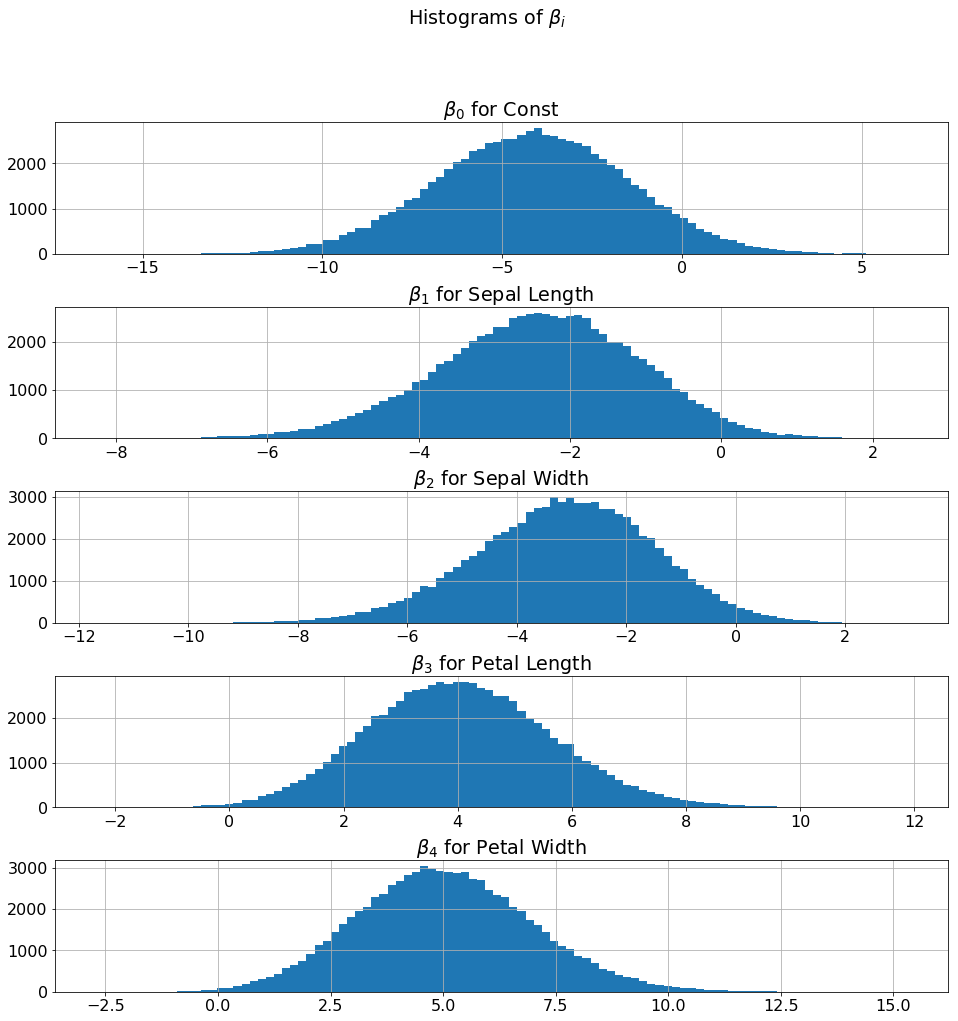

In [35]:
# Extract the sampled values of beta from the model trace
beta_samples = model_trace['beta']
# Feature names for plots
beta_names = ['Const', 'Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width']

# Visualize the betas
fig, axs = plt.subplots(5)
fig.suptitle(r'Histograms of $\beta_i$')
fig.set_size_inches([16, 16])
plt.subplots_adjust(hspace=0.4)
for i, ax in enumerate(axs):
    beta_name = beta_names[i]
    ax.set_title(f'$beta_{i}$ for {beta_name}'.replace(r'$beta', r'$\beta'))
    ax.hist(beta_samples[:,i], bins=100)
    ax.grid()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000017AC09A34E0>,
      dtype=object)

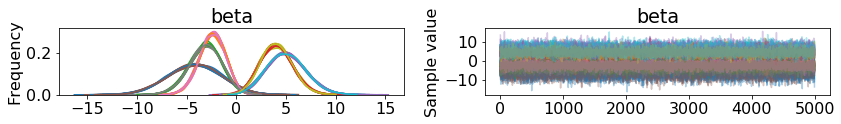

In [36]:
# Reduce font size for these plots
matplotlib.rcParams.update({'font.size': 16})
# Run the traceplot for beta as a composite
pm.traceplot(model_trace, varnames=['beta'])

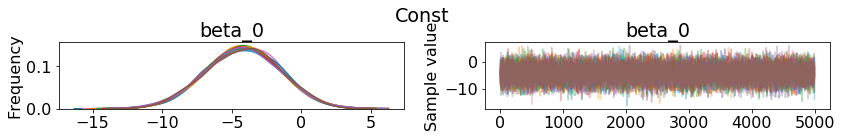

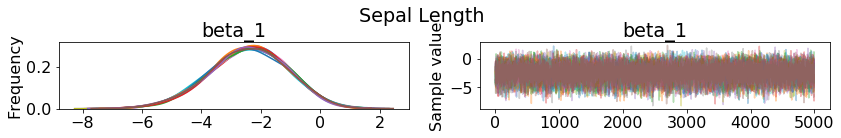

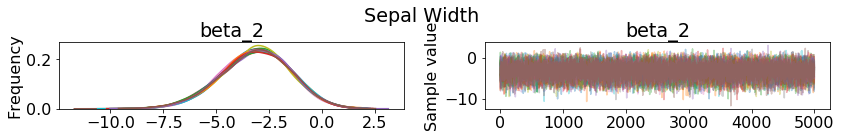

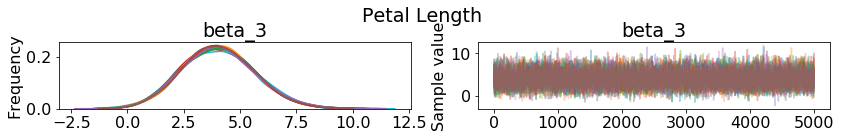

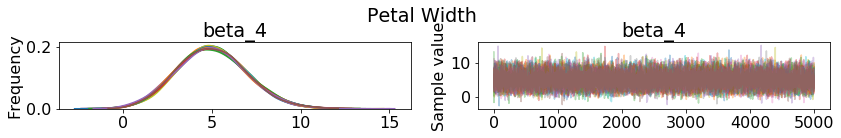

In [37]:
# Run the traceplot for beta_i's individually
var_names = ['beta_0', 'beta_1', 'beta_2', 'beta_3', 'beta_4']
for i in range(n):
    pm.traceplot(model_trace, varnames=[var_names[i]])
    plt.suptitle(beta_names[i])

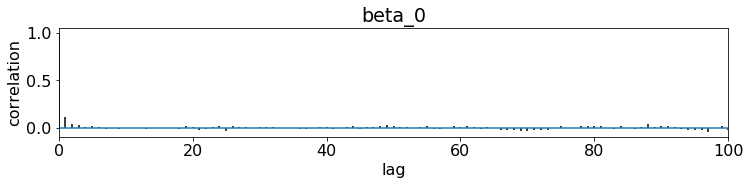

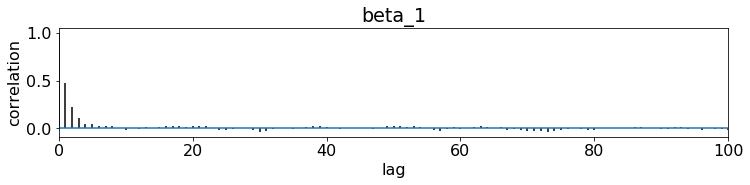

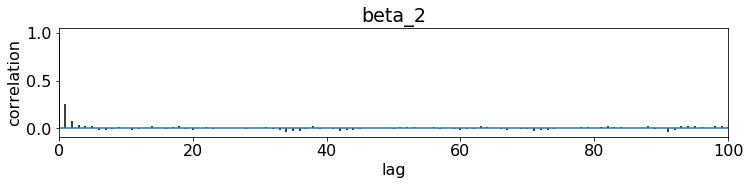

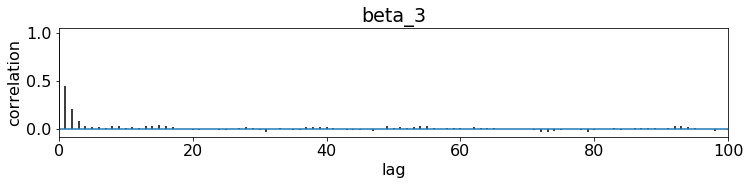

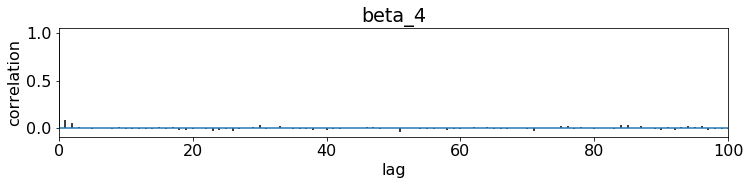

In [38]:
# Run a small trace with just one chain so the autocorrelation plots are legible
try:
    model_trace_small = vartbl['model_trace_small']
except:    
    with model:
        stepper = pm.NUTS()
        model_trace_small = pm.sample(draws=5000, stepper=stepper, tune=1000, chains=1, cores=16)
    vartbl['model_trace_small'] = model_trace_small
    
# Run the autocorrelation plots for beta_i's individually
for i in range(n):
    pm.autocorrplot(model_trace_small, varnames=[var_names[i]])

**2.6** Based on your samples construct an estimate for the posterior mean.

**2.7** Select at least 2 datapoints and visualize a histogram of the posterior probabilities.  Denote the posterior mean and MAP on your plot for each datapoint

Although having the posterior probabilities is nice, they are not enough.  We need to think about how to make predictions based on our machinery.  If we define the following:

 - $p_{MEAN}$: using the posterior mean betas to generate probabilities for each data point
 - $p_{MAP}$: using the posterior MAP betas to generate probabilities for each data point
 - $p_{CDF}$: using the fraction of your posterior samples have values above 0.5 for each data point
 - $p_{PP}$:  using the fraction of 1s out of the samples drawn from the posterior predictive distribution for each data point

**2.8** Plot the distributions of $p_{MEAN}$, $p_{CDF}$, $p_{MAP}$ and $p_{PP}$ over all the data points in the training set. How are these different?

**2.9** Plot the posterior-predictive distribution of the misclassification rate with respect to the true class identities $y(x)$ of the data points $x$ (in other words you are plotting a histogram with the misclassification rate for the $n_{trace}$ posterior-predictive samples) on the training set.

**2.10** For every posterior sample, consider whether the data point ought to be classified as a 1 or 0 from the $p>0.5 \implies y=1$ decision theoretic prespective. Using the MLDT defined above, overlay a plot of the histogram of the misclassification rate for the posterior on the corresponding plot for the posterior-predictive you constructed in 2.9.  Which case (from posterior-predictive or from-posterior) has a wider mis-classification distribution? 

**2.11** Repeat 2.9 and 2.10 for the test set (i.e. make predictions).  Describe and interpret the widths of the resulting distributions.

<div class="answer-separator">
------------------------
</div>

## Question 3 - Our Yelp Restaurant Review is in and the Fish is So Raw!

**no coding required**

In this course, we've spent a lot of time learning algorithms for performing inference on complex models. We've also spent time using these models to make decisions regarding our data. But in nearly every assignment, the model for the data is specified in the problem statement. In real life, the creative and, arguably, much more difficult task is to start with a broadly defined goal and then to customize or create a model which will meet this goal in some way. 


This homework problem is atypical in that it does not involve any programming or (necessarily) difficult mathematics/statistics. The process of answering these questions *seriously* will however give you an idea of how one might create or select a model for a particular application and your answers will help you with formalizing the model if and when you're called upon to do so.

***Grading:*** *We want you to make a genuine effort to mold an ambiguous and broad real-life question into a concrete data science or machine learning problem without the pressure of getting the "right answer". As such, we will grade your answer to this homework question on a pass/fail basis. Any reasonable answer that demonstrates actual effort will be given a full grade.*

We've compiled for you a fairly representative selection of [Yelp reviews](https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlo4e4ari3r4wd%2Fj9vjyzv62x149%2Fjoe92vh7ni6e%2Fyelp_reviews.zip for a (now closed) sushi restaurant called Ino's Sushi in San Francisco. Read the reviews and form an opinion regarding the various qualities of Ino's Sushi. Answer the following:

3.1. If the task is to summarize the quality of a restaurant in a simple and intuitive way, what might be problematic with simply classifying this restaurant as simply "good" or "bad"? Justify your answers with specific examples from the dataset.

3.2. For Ino's Sushi, categorize the food and the service, separately, as "good" or "bad" based on all the reviews in the dataset. Be as systematic as you can when you do this.

  (**Hint:** Begin by summarizing each review. For each review, summarize the reviewer's opinion on two aspects of the restaurant: food and service. That is, generate a classification ("good" or "bad") for each aspect based on what the reviewer writes.) 
  
3.3. Identify statistical weaknesses in breaking each review down into an opinion on the food and an opinion on the service. That is, identify types of reviews that make your method of summarizing the reviewer's optinion on the quality of food and service problemmatic, if not impossible. Use examples from your dataset to support your argument. 

3.4. Identify all the ways in which the task in 3.2 might be difficult for a machine to accomplish. That is, break down the classification task into simple self-contained subtasks and identify how each subtask can be accomplished by a machine (i.e. which area of machine learning, e.g. topic modeling, sentiment analysis etc, addressess this type of task).

3.5. Now let us think of a different problem, a regression problem in which our aim is to predict and do inference on what rating a given user of Yelp might give a particular restaurant. How might you estimate the across-user quality of a restaurant from data? And how might you estimate the across-restaurant curmudgeonlyness of a user?

3.6 Additionally, consider a "space of latent factors" where aspects of the user's taste interact with aspects of the restaurant. An example of such a factor might be the user's propensity to get emotional after having the perfect filet-mignon. How might you combine this information with that in 3.5 to improve your prediction and inference?

**Gratuitous Titular Reference**:  

[Sushi is not raw fish](http://www.todayifoundout.com/index.php/2011/12/sushi-is-not-raw-fish)

![](https://i.imgflip.com/pnawi.jpg)

[More Gordon Ramsey memes](https://knowyourmeme.com/memes/people/gordon-ramsay)

<div class="answer-separator">
------------------------
</div>